In [1]:
from timegym.utils import runwrite

# Synthetic.py

## Boilerplate Code

In [2]:
%%runwrite timegym/data/synthetic.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.artificial import recipe as rcp
from sktime.forecasting.model_selection import temporal_train_test_split

In [3]:
plt.style.use('dark_background')

The oracle is the ideal prediction:

1. In the case of a point forecasting, the oracle is the true mean.
2. In the case of probabilistic forecasting, the oracle is the true distribution.

In [4]:
%%runwrite -a timegym/data/synthetic.py

class SyntheticSeries:
    def __init__(self, length, test_size, shortname=None):
        """
        TODO function description
        """
        self.length = length
        self.test_size = test_size
        self.target = self.shortname = shortname 
        self.components = self.generate_components()
        if shortname is None: self.target = self.shortname = self.components.columns[-1]
    
    
    def generate_components(self):
        """
        TODO function description
        """
        raise NotImplementedError
    
    
    def get_data(self, generate_new=True, include_oracle=True):
        """
        TODO function description
        """
        if generate_new: 
            self.components = self.generate_components()
        y_train, y_test = temporal_train_test_split(self.components[self.target], test_size=self.test_size)
        if include_oracle:
            return y_train, y_test, self.components['oracle']
        else: 
            return y_train, y_test
    
    
    def plot_timeseries(self, **kwargs):
        """
        TODO function description
        """
        ax = self.components['oracle'].plot(marker="o",  markersize=5, **kwargs)
        self.components[self.target].plot(ax=ax, linewidth=2)
        return ax
    
    
    def plot_components(self, 
                        oracle_on_target=True, 
                        bins_size=20, 
                        histogram_components=['target', 'noise'], 
                        scatter_components=['target', 'noise'],
                        show_title=False):
        """
        TODO function description
        """
        fig, axes = plt.subplots(nrows=self.components.shape[1], squeeze=False, 
                                 figsize=(20, 3*self.components.shape[1]))
        if show_title:
            fig.suptitle(self.target, fontsize=14)
        
        histogram_components = [self.target if c=='target' else c for c in histogram_components]
        scatter_components = [self.target if c=='target' else c for c in scatter_components]
        for ax, label in zip(axes[:, 0], self.components):
            if label in histogram_components:
                ax.hist(self.components[label], bins=self.length//bins_size,
                        orientation="horizontal", color='#3333FF55')
            if label in scatter_components:
                ax.scatter(x=range(self.components.shape[0]), 
                           y=self.components[label], s=5)
            else:
                self.components[label].plot(ax=ax, linewidth=2)
            ax.set_xlim(xmin=0)
            ax.grid(False)
            ax.set_ylabel(label)
        
        if oracle_on_target: 
            self.components.oracle.plot(ax=axes[-1, 0], linewidth=1)

        return axes

In [5]:
%%runwrite -a timegym/data/synthetic.py

class GluonSyntheticSeries(SyntheticSeries):
    def __init__(self, length, test_size, **recipe):
        """
        TODO function description
        """
        self.recipe = recipe
        self.gluonts_recipe = [(label, recipe[label]) for label in recipe]
        super().__init__(length, test_size, self.gluonts_recipe[-1][0])
    
    def generate_components(self):
        """
        TODO function description
        """
        # generates a dataframe, with timeseries components
        # the last two columns should be the oracle and the final timeseries
        components = rcp.evaluate(self.gluonts_recipe, self.length)
        for label in components:
            if components[label].shape[0] == 1:
                components[label] = np.repeat(components[label], self.length)
        return pd.DataFrame(components, dtype=float)

## White Noise

In [6]:
%%runwrite -a timegym/data/synthetic.py

gaussian = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.RandomUniform(-100, 100, shape=1),
    Gaussian = rcp.RandomGaussian(rcp.RandomUniform(0.01, 10, shape=1)) + 'oracle'
)

array([[<AxesSubplot:ylabel='oracle'>],
       [<AxesSubplot:ylabel='Gaussian'>]], dtype=object)

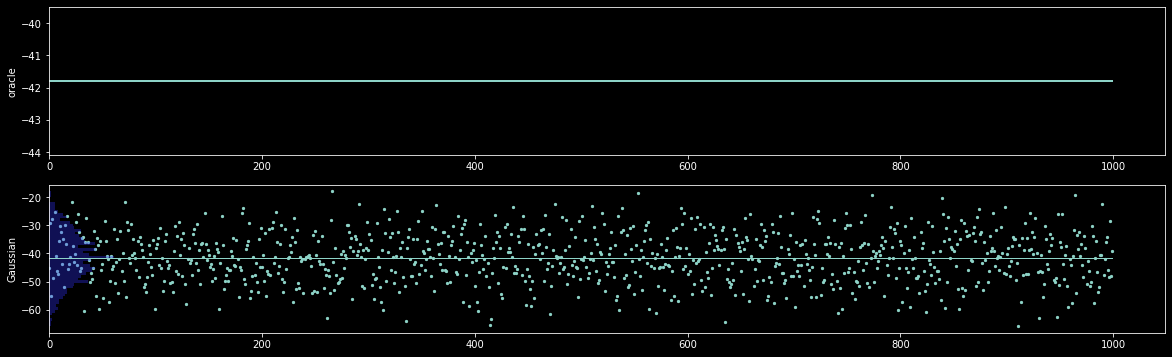

In [7]:
gaussian.plot_components()

In [8]:
%%runwrite -a timegym/data/synthetic.py

uniform = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    range = rcp.RandomUniform(0.01, 10, shape=1),
    oracle = rcp.RandomUniform(-100, 100, shape=1),
    Uniform = rcp.RandomUniform(rcp.Ref('oracle')-rcp.Ref('range'), 
                                rcp.Ref('oracle')+rcp.Ref('range'))
)

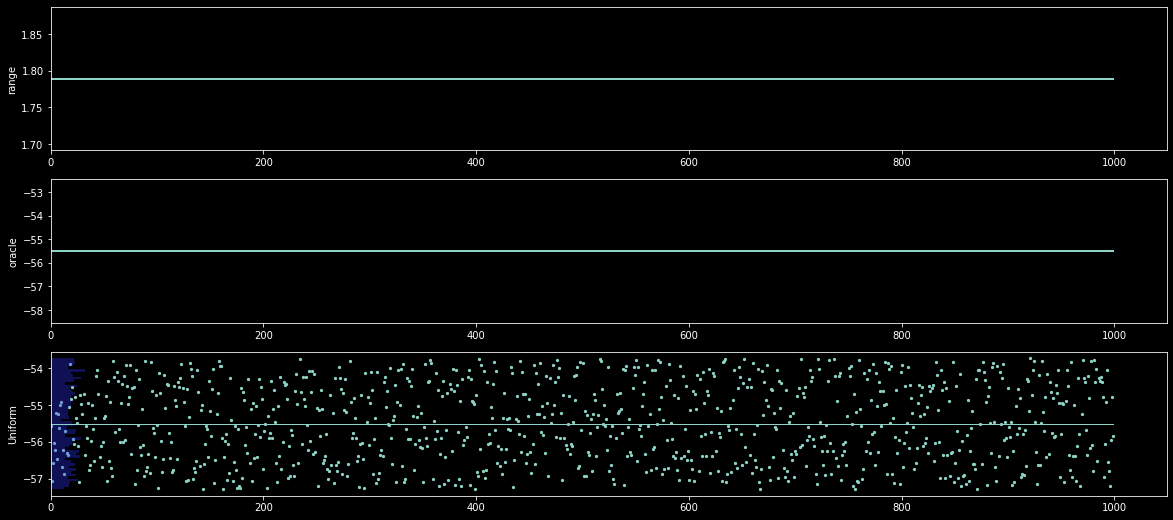

In [9]:
uniform.plot_components();

In [10]:
%%runwrite -a timegym/data/synthetic.py

symdirichlet = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    intercept = rcp.RandomUniform(-100, 100, shape=1),
    alpha = rcp.RandomUniform(0.01, 100, shape=1),
    oracle = rcp.Add([1/300, 'intercept']), # 1/lengh
    SymmetricDirichlet = rcp.RandomSymmetricDirichlet('alpha') + 'intercept'
)

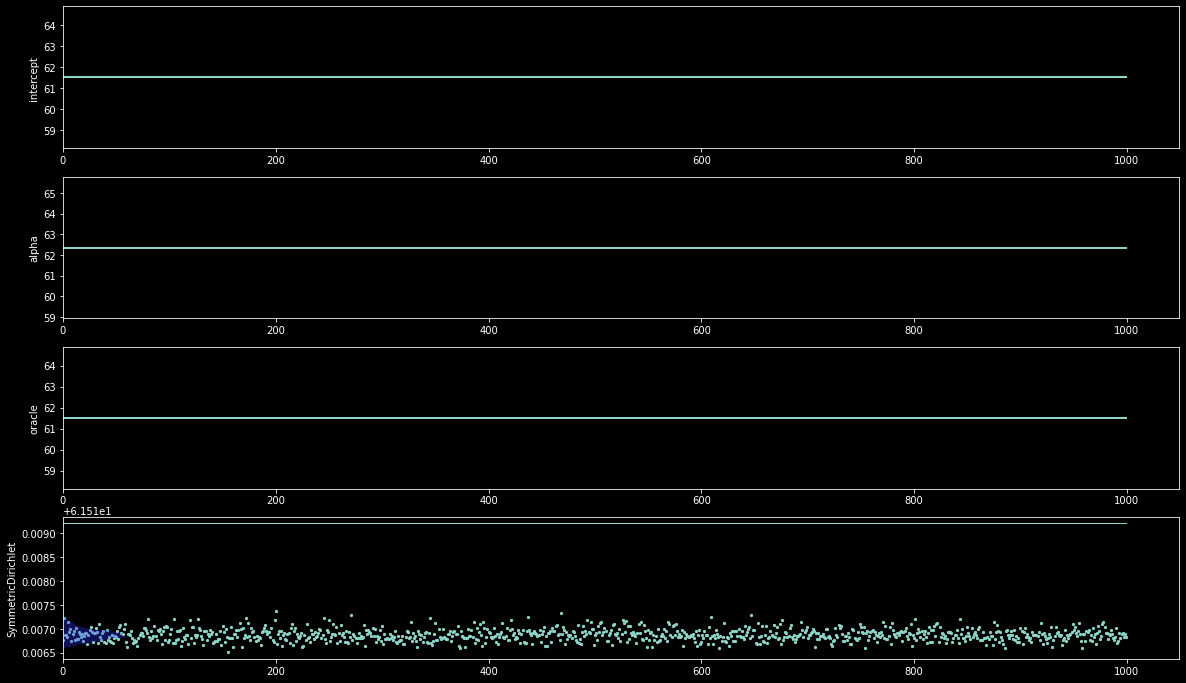

In [11]:
symdirichlet.plot_components();

## Geometric Brownian Motion


Yearly stock returns, for example, are known to a follow log-normal distributions

> If the random variable X is log-normally distributed, then Y = ln(X) has a normal distribution. - http://people.duke.edu/~hpgavin/cee201/ProbabilityDistributions.pdf

This implies that all statistics such as the mean (aka average), median, standard deviation based on returns assume its distribution incorrectly. Nassim N. Taleb pointed this out in [ref].

We should me modeling this using 

In [12]:
mean = 0.08# np.random.exponential(0.01)
std = mean**np.random.uniform(0.3, 0.7)
n = 5000000
mean, std, n

(0.08, 0.2619626111894754, 5000000)

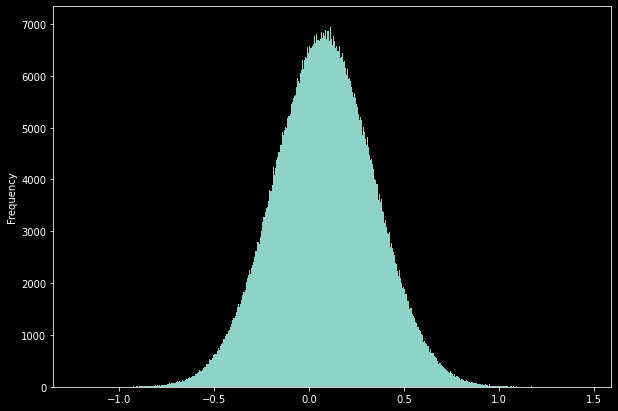

In [13]:
# numpy's normal distribution
normal_distribution = np.random.normal(mean, std, n)
pd.Series(normal_distribution).plot.hist(bins=3000, figsize=(10,7));

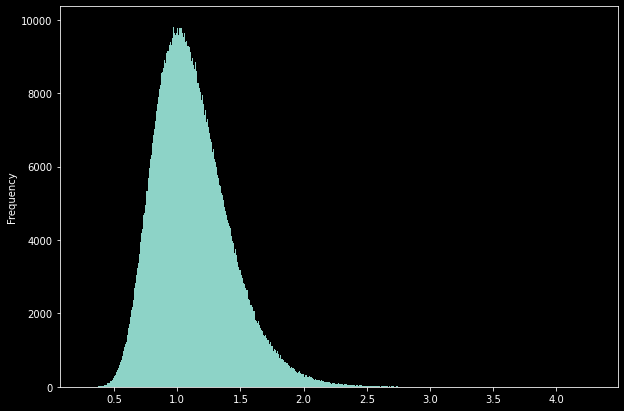

In [14]:
# numpy's lognormal distribution 
lognormal_distribution = np.random.lognormal(mean, std, n)
pd.Series(lognormal_distribution).plot.hist(bins=3000, figsize=(10,7));

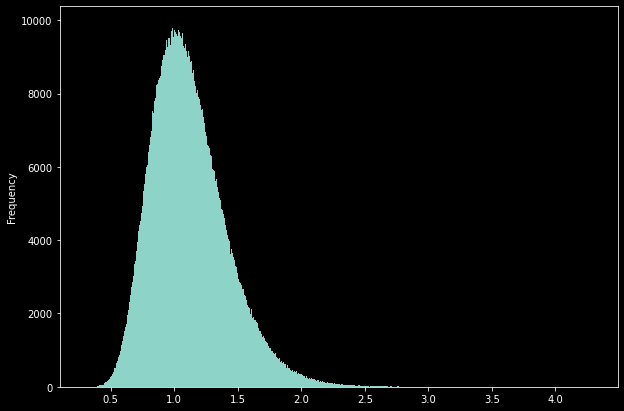

In [15]:
# exp(normal) way
pd.Series(np.exp(normal_distribution)).plot.hist(bins=3000, figsize=(10,7));

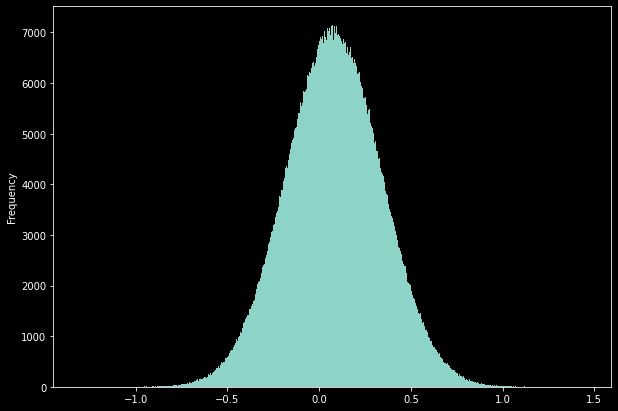

In [16]:
# log(lognormal) way
pd.Series(np.log(lognormal_distribution)).plot.hist(bins=3000, figsize=(10,7));

In [17]:
%%runwrite -a timegym/data/synthetic.py

class GeometricBrownianMotion(SyntheticSeries):    
    def __init__(self, length, test_size):
        super().__init__(length, test_size, 'Brownian Motion')
        
    def generate_components(self):
        # define initial value of time series
        initial = np.random.exponential(1000)
        # define mean and std of underlying normal distributiion
        mean = np.random.exponential(0.0005)
        std = np.random.uniform(0.01, 0.03)
        
        # x[t] = x[t-1] * lognormal(mean, std)
        # returns are said to be log-normally distributed.
        # this means that the latent variable (also known as noise during simulation) 
        # is normally distributed, but suffers an exp() transformation applied to it.
        #factor = np.exp(np.cumsum(np.log(np.random.lognormal(mean, std, self.length))))
        #factor = np.exp(np.cumsum(np.log(np.exp(np.random.normal(mean, std, self.length)))))
        series = initial * np.exp(np.cumsum(np.random.normal(mean, std, self.length)))
        
        #oracle = np.empty(shape=self.length)
        #oracle[1:] = series[:-1] * np.exp(mean)
        #oracle[0] = np.nan
        oracle = initial * np.exp(np.arange(self.length) * mean)
        
        return pd.DataFrame({'oracle': oracle, self.shortname: series})

brownian = GeometricBrownianMotion(length=1000, test_size=300)

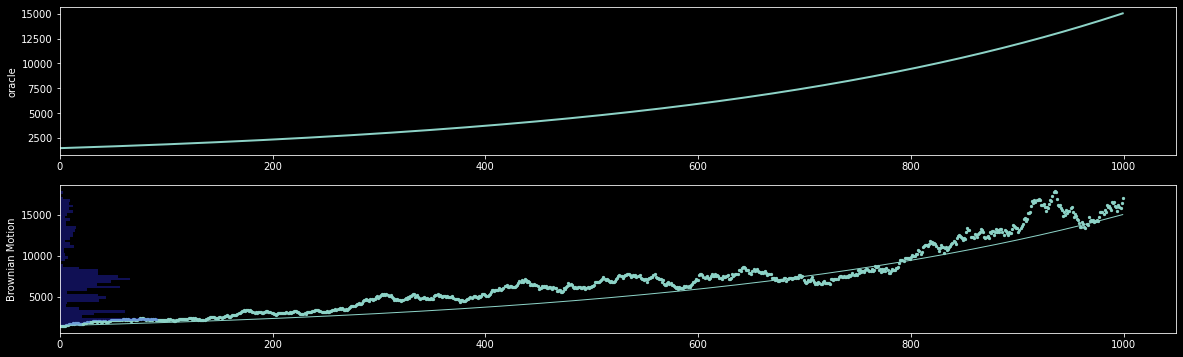

In [18]:
brownian.plot_components(oracle_on_target=True);

Are log-returns best modeled by normal distributions?

## Trend

In [19]:
%%runwrite -a timegym/data/synthetic.py

trend_clean = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(2, 10, shape=1)),
    Trend = 'oracle'
)

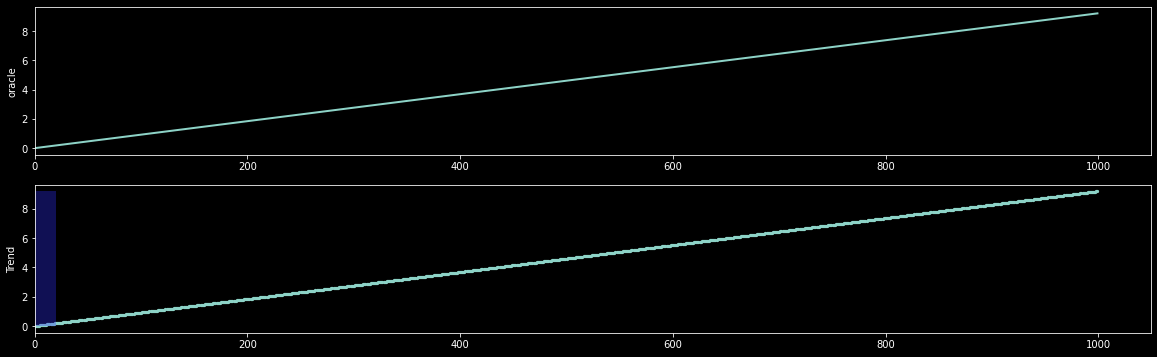

In [20]:
trend_clean.plot_components(oracle_on_target=False);

In [21]:
%%runwrite -a timegym/data/synthetic.py

trend_small_noise = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.5, 1, shape=1)),
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(3, 10, shape=1)),
    Trend = rcp.Add(['oracle','noise'])
)

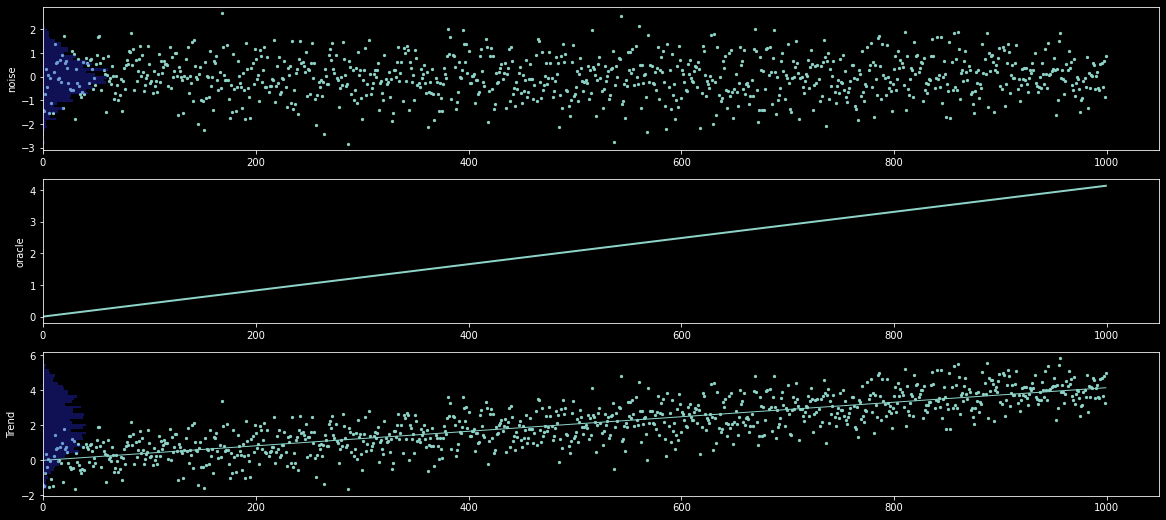

In [22]:
trend_small_noise.plot_components();

In [23]:
%%runwrite -a timegym/data/synthetic.py

trend_big_noise = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(3, 5, shape=1)),
    oracle = rcp.LinearTrend(slope=rcp.RandomUniform(3, 10, shape=1)),
    Trend = rcp.Add(['oracle','noise'])
)

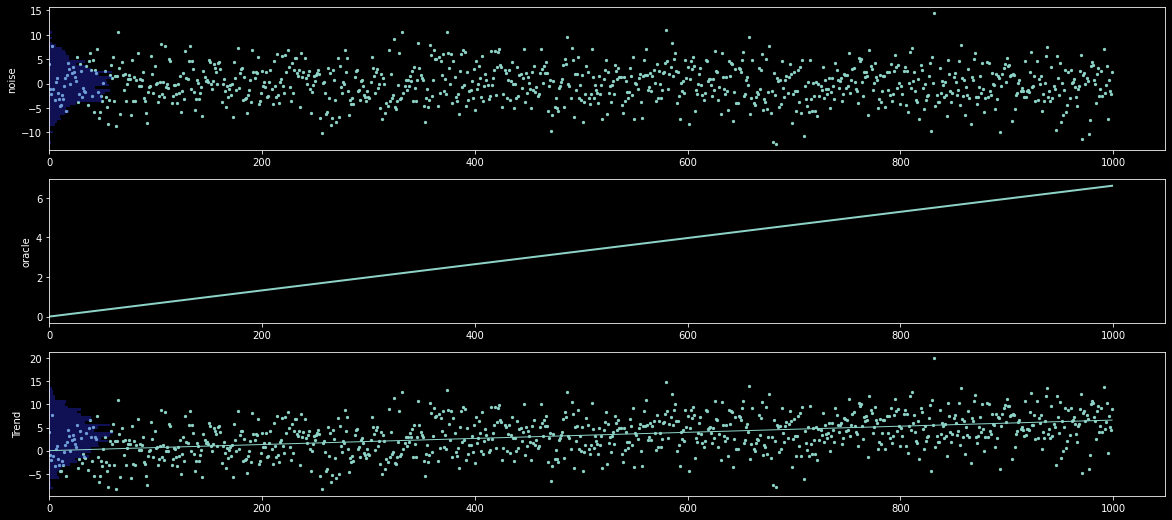

In [24]:
trend_big_noise.plot_components();

## Seasonality

In [25]:
%%runwrite -a timegym/data/synthetic.py

seasonality = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    Seasonality = 'oracle'
)

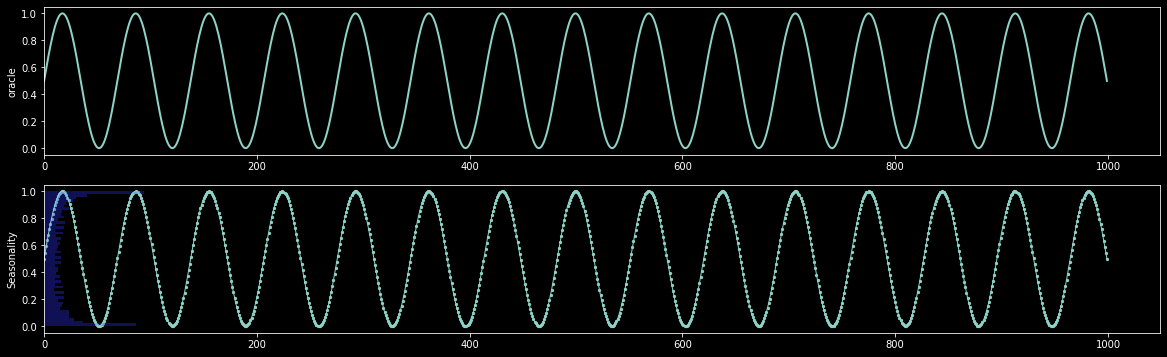

In [26]:
seasonality.plot_components();

In [27]:
%%runwrite -a timegym/data/synthetic.py

two_seasonalities = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    seasonality1 = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    seasonality2 = rcp.SmoothSeasonality(period=rcp.RandomUniform(100, 200, shape=1), phase=0),
    oracle = rcp.Add(['seasonality1','seasonality2']),
    TwoSeasonalities = 'oracle'
)

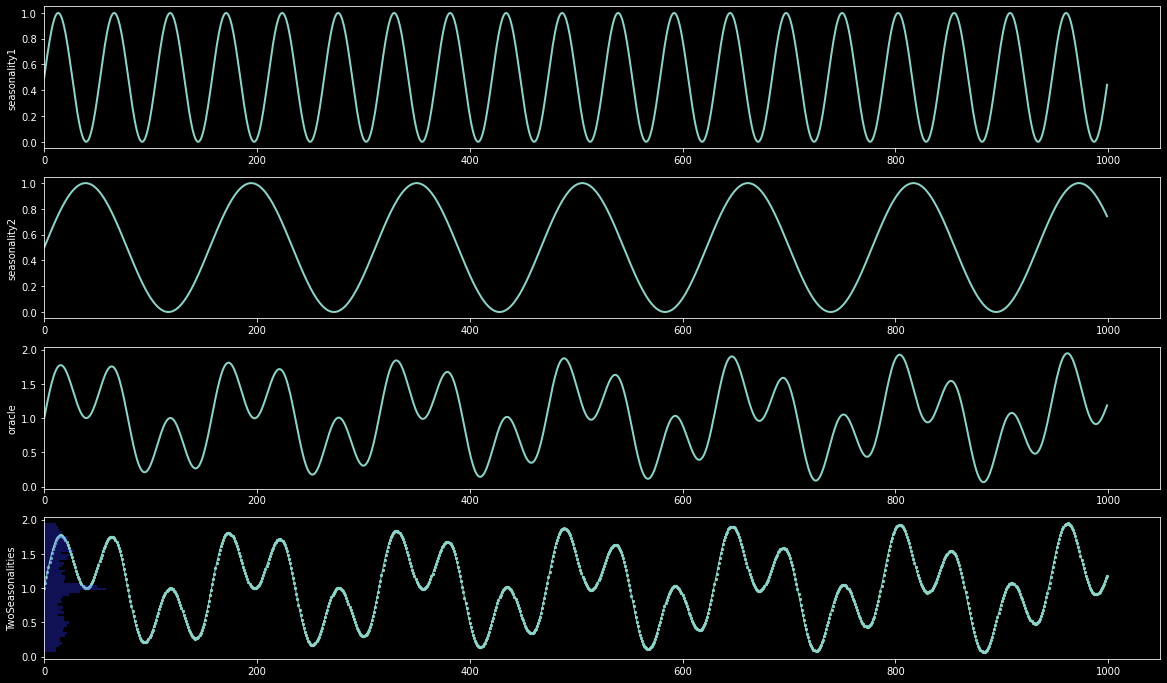

In [28]:
two_seasonalities.plot_components();

In [29]:
%%runwrite -a timegym/data/synthetic.py

seasonality_noisy = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 200, shape=1), phase=0),
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 0.8, shape=1)),
    SeasonalityNoisy = rcp.Add(['oracle', 'noise'])
)

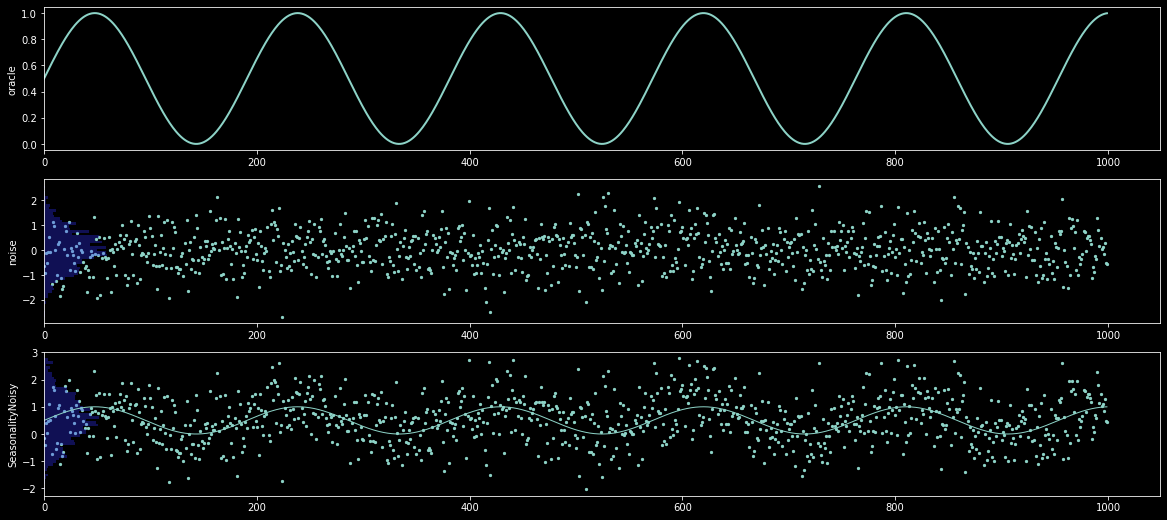

In [30]:
seasonality_noisy.plot_components();

In [31]:
%%runwrite -a timegym/data/synthetic.py

two_seasonalities_noisy = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    seasonality1 = rcp.SmoothSeasonality(period=rcp.RandomUniform(20, 100, shape=1), phase=0),
    seasonality2 = rcp.SmoothSeasonality(period=rcp.RandomUniform(100, 200, shape=1), phase=0),
    oracle = rcp.Add(['seasonality1','seasonality2']),
    noise = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 0.8, shape=1)),
    TwoSeasonalitiesNoisy = rcp.Add(['oracle', 'noise'])
)

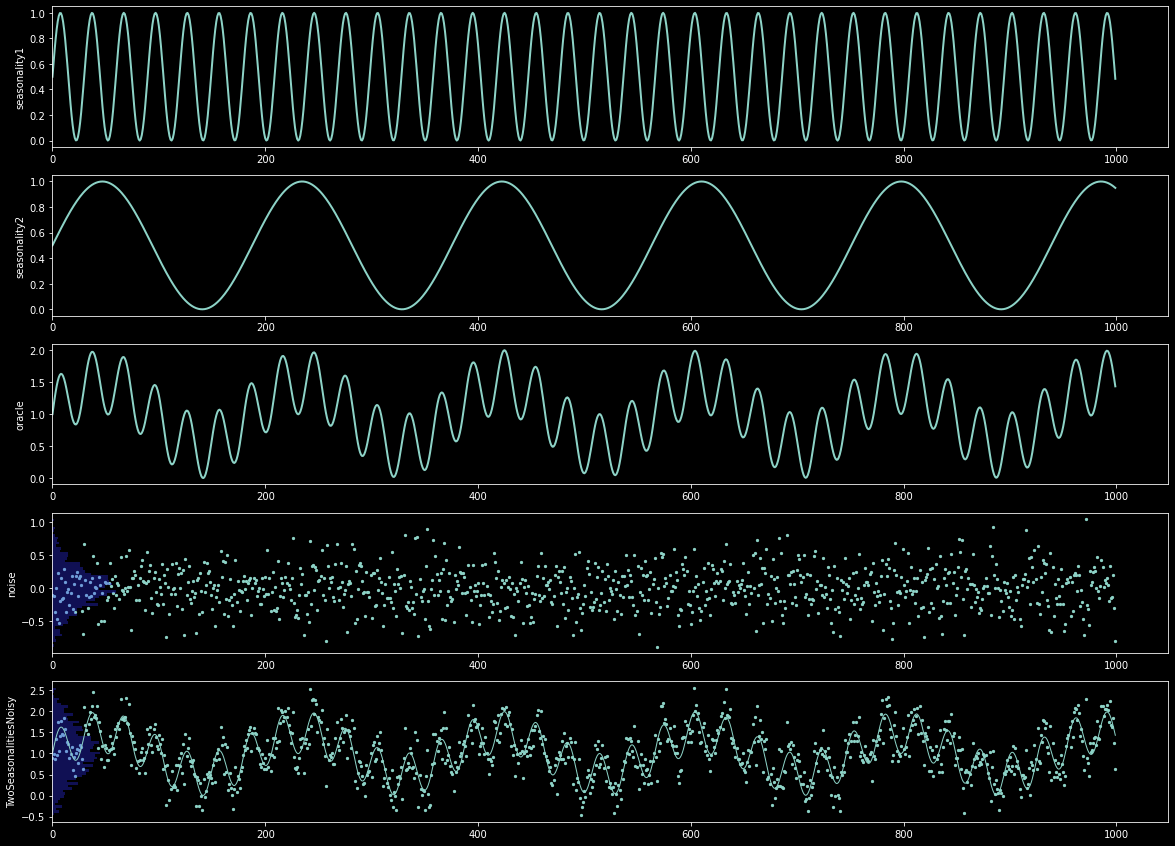

In [32]:
two_seasonalities_noisy.plot_components();

## Trend + Seasonality

In [33]:
%%runwrite -a timegym/data/synthetic.py

trend_seasonality = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    trend = rcp.LinearTrend(slope=rcp.RandomUniform(1, 10, shape=1)),
    seasonality = rcp.SmoothSeasonality(period=rcp.RandomUniform(10, 200, shape=1), phase=0),
    oracle = rcp.Add(['trend', 'seasonality']),
    TrendSeasonality = 'oracle'
)

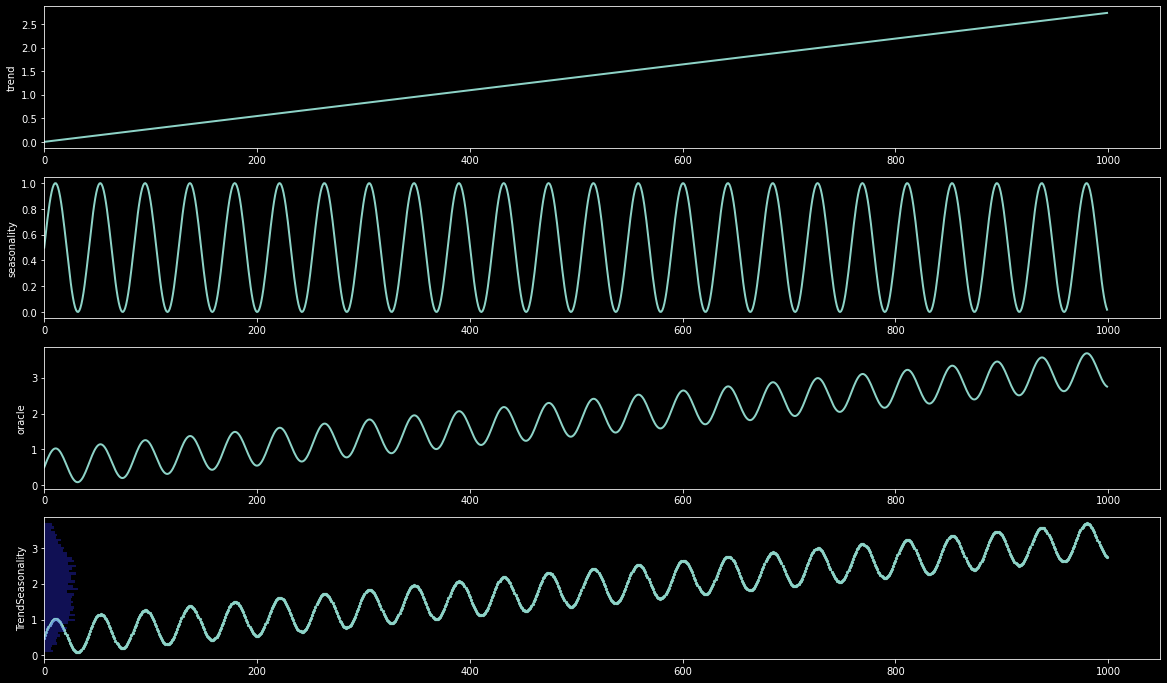

In [34]:
trend_seasonality.plot_components();

## Weekly patterns

In [35]:
%%runwrite -a timegym/data/synthetic.py

class WeeklySyntheticSeries(SyntheticSeries):  
    def __init__(self, length, test_size):
        super().__init__(length, test_size, 'Weekly Patterns')
        
    def generate_components(self):
        # define mean and std to reasonable values
        mean1 = np.random.exponential(10)
        std1 = mean1**np.random.uniform(0.1, 0.4)
        weekdays = np.random.normal(mean1, std1, size=self.length)
        
        mean2 = np.random.exponential(10)
        std2 = mean2**np.random.uniform(0.1, 0.4)
        weekends = np.random.normal(mean2, std2, size=self.length)

        week_pattern = np.resize([1, 1, 1, 1, 1, 0, 0], self.length)
        timeseries = weekdays*week_pattern + weekends*(1-week_pattern)
        oracle = mean1*week_pattern + mean2*(1-week_pattern)
        
        return pd.DataFrame({
            'weekdays': weekdays,
            'weekends': weekends,
            'oracle': oracle,
            self.shortname: timeseries
        })

weekdays = WeeklySyntheticSeries(length=300, test_size=30)

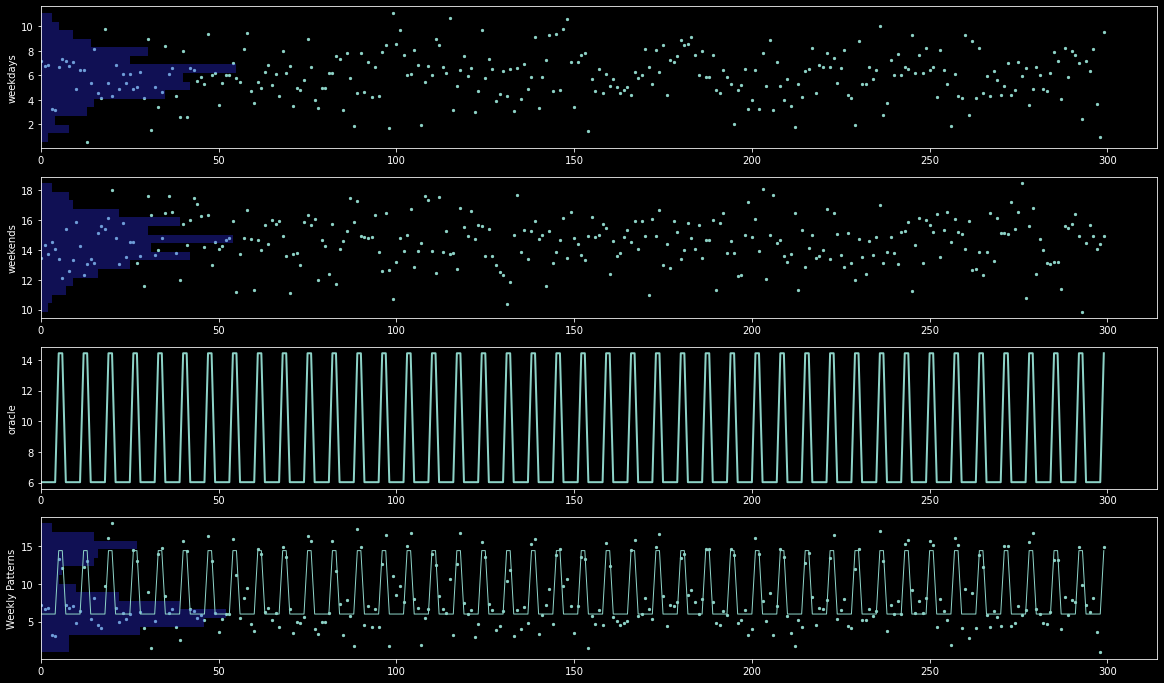

In [36]:
weekdays.plot_components(scatter_components=['target', 'weekdays', 'weekends'],
                         histogram_components=['target', 'weekdays', 'weekends']);

## Anomalies / Outliers

In [37]:
%%runwrite -a timegym/data/synthetic.py

anomalies = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    trend = rcp.LinearTrend(slope=2),
    seasonality = rcp.SmoothSeasonality(period=250, phase=0),
    noise = rcp.RandomGaussian(stddev=0.4),
    anomalies = rcp.RandomUniform(2, 4) * rcp.RandomGaussian() * rcp.RandomBinary(prob=0.01),
    oracle = rcp.Add(['trend', 'seasonality']),
    TrendSeasonalityAnomalies = rcp.Add(['trend', 'seasonality', 'noise', 'anomalies'])
)

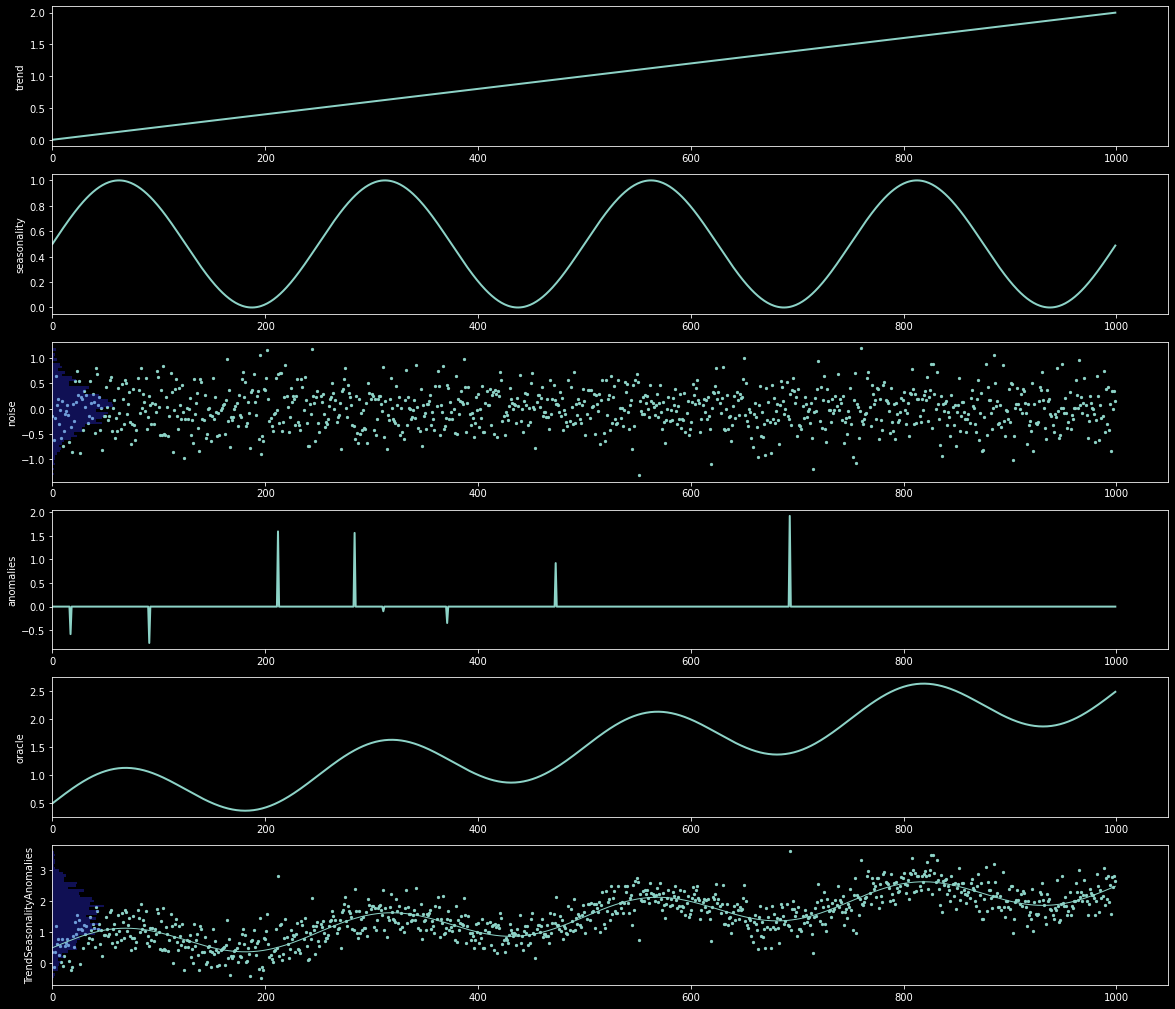

In [38]:
anomalies.plot_components();

## Concept Drift

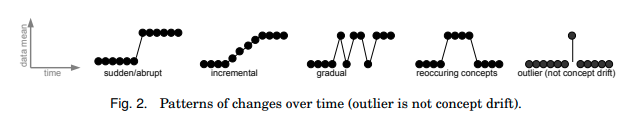

Source: [A survey on concept drift adaptation (Gama et al, 2014)](http://www.liaad.up.pt/area/jgama/reviewCD_methods.pdf)

So far, we've modelered reoccuring concepts.

Reoccuring concepts are similar to gradual concepts.

Let's model these 

TODO:

* add incremental concept drift
* add sudden / abrupt drift
* add intermittent concept drift *
* add to references 

TODO:

* add concept drift applied to std!
* other types of drift
* Yassine's concept glitch

### Recurrent Concept Drift

In [39]:
%%runwrite -a timegym/data/synthetic.py

two_markov = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.01, 0.01) * rcp.RandomUniform(8, 15, shape=1),
    TwoMarkovStates = 'oracle'
)

In [40]:
two_markov.get_data()

(0      13.785351
 1      13.785351
 2      13.785351
 3      13.785351
 4      13.785351
          ...    
 695     0.000000
 696     0.000000
 697     0.000000
 698     0.000000
 699     0.000000
 Name: TwoMarkovStates, Length: 700, dtype: float64,
 700    0.0
 701    0.0
 702    0.0
 703    0.0
 704    0.0
       ... 
 995    0.0
 996    0.0
 997    0.0
 998    0.0
 999    0.0
 Name: TwoMarkovStates, Length: 300, dtype: float64,
 0      13.785351
 1      13.785351
 2      13.785351
 3      13.785351
 4      13.785351
          ...    
 995     0.000000
 996     0.000000
 997     0.000000
 998     0.000000
 999     0.000000
 Name: oracle, Length: 1000, dtype: float64)

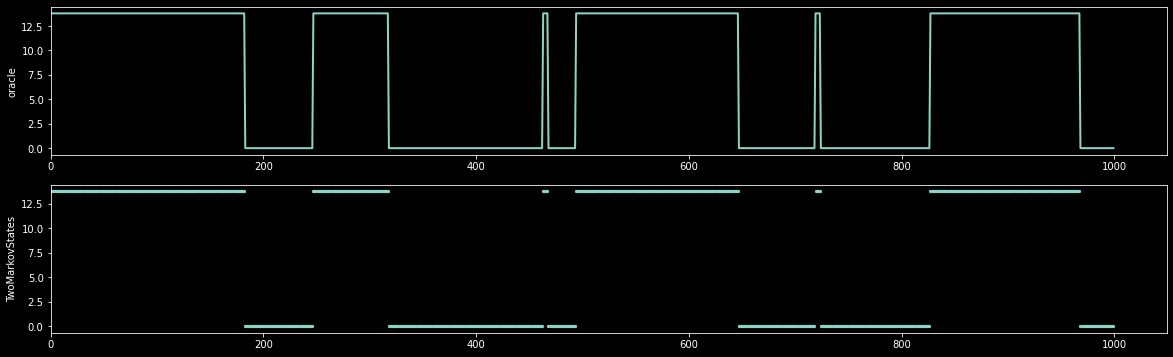

In [41]:
two_markov.plot_components(oracle_on_target=False, histogram_components=[]);

In [42]:
%%runwrite -a timegym/data/synthetic.py

two_markov_fast = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.1, 0.1) * rcp.RandomUniform(8, 15, shape=1),
    TwoMarkovStatesFast = 'oracle'
)

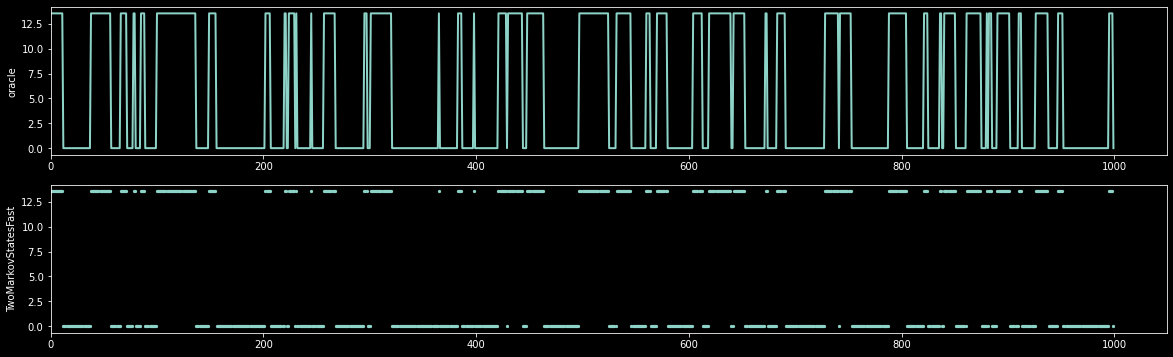

In [43]:
two_markov_fast.plot_components(oracle_on_target=False, histogram_components=[]);

In [44]:
%%runwrite -a timegym/data/synthetic.py

two_gaussians = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.5, 0.5) * rcp.RandomUniform(5, 10, shape=1),
    TwoGaussians = rcp.RandomGaussian(stddev=rcp.RandomUniform(0.1, 2, shape=1)) + 'oracle'
)

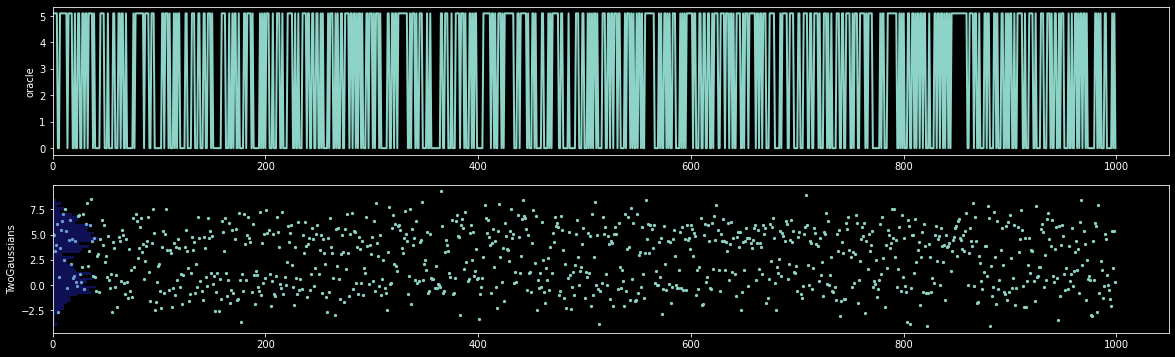

In [45]:
two_gaussians.plot_components(oracle_on_target=False);

In [46]:
%%runwrite -a timegym/data/synthetic.py

two_gaussians_imbalanced = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.3, 0.7) * rcp.RandomUniform(8, 15, shape=1),
    TwoGaussiansImbalanced = rcp.RandomGaussian(stddev=rcp.RandomUniform(1, 3, shape=1)) + 'oracle'
)

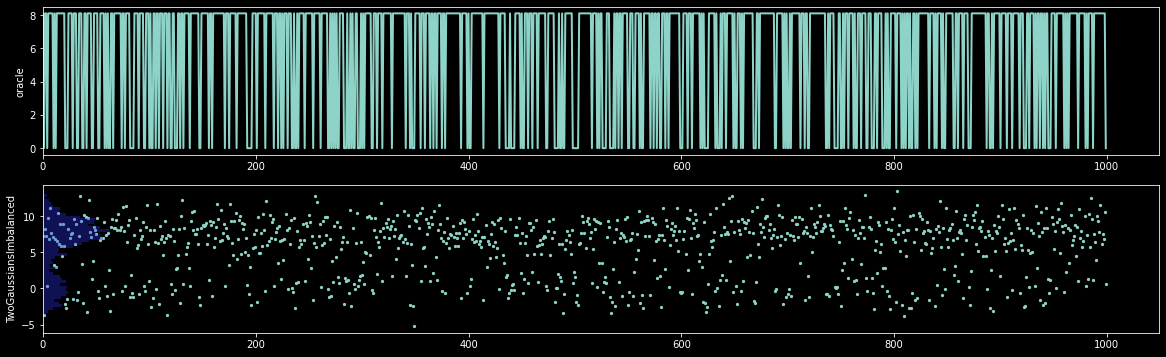

In [47]:
two_gaussians_imbalanced.plot_components(oracle_on_target=False);

In [48]:
%%runwrite -a timegym/data/synthetic.py

two_gaussians_markov = GluonSyntheticSeries(
    length = 1000, 
    test_size = 300,
    oracle = rcp.BinaryMarkovChain(0.05, 0.1) * rcp.RandomUniform(8, 15, shape=1),
    TwoGaussianMarkov = rcp.RandomGaussian(stddev=rcp.RandomUniform(1, 3, shape=1)) + 'oracle'
)

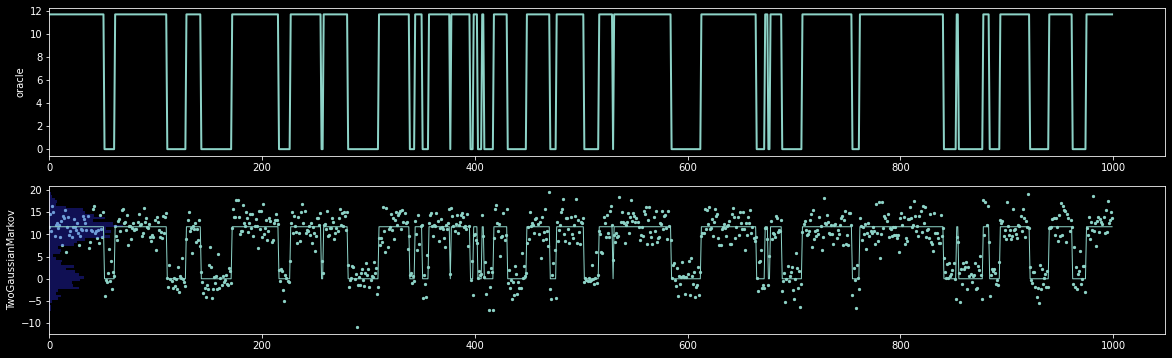

In [49]:
two_gaussians_markov.plot_components();

In [50]:
%%runwrite -a timegym/data/synthetic.py

#class ConceptDriftChallenges(CompositeChallenges):
#    
#    def __init__(self, challenge1, challenge2, drift_probability):
#        """
#        Simulates the effect of recurrent concept drift by using a markov chain that changes between challenges.
#        The initializer takes a list drift_probability, that represents the probability of drifting from challenges.
#        """
#        assert len(challeges) == len(drift_probability)
#
#    
#class AverageDriftChallenges(CompositeChallenges):
#    
#    def __init__(self, challenges, weights, activate_probability, deactivate_probability):
#        """
#        Simulates the effect of averaging several challenges that may or may not be active at a certain time.
#        activate_probability represents the probabilities of challenges becoming active.
#        deactivate_probability represents the probabilities of challenges becoming innactive.
#        """
#        assert len(challeges) == len(weights) == len(activate_probability) == len(deactivate_probability)
#        
#class MetaChallenges:
#    weights are dynamic, they change between 0 to 1 like timeseries, some of them are binary, others are smooth.
#    The weights themselves are time series that we wish to predict.
#    

![](input_car_concept_drift.png)

## Frequency Domain

## Composite

In [51]:
%%runwrite -a timegym/data/synthetic.py

class AverageSyntheticSeries(SyntheticSeries):
    
    def __init__(self, synthetic_series, weights):
        """
        Weighted average of the timeseries of many synthetic_series.
        """
        assert len(synthetic_series) == len(weights)
        for i in range(1, len(synthetic_series)):
            assert synthetic_series[0].length == synthetic_series[i].length
            assert synthetic_series[0].test_size == synthetic_series[i].test_size
        self.synthetic_series = synthetic_series
        self.weights = weights
        
        super().__init__(synthetic_series[0].length, synthetic_series[0].test_size)
        # TODO check that the lengths and test_sizes are the same
        # if no check, simply increase it to the proportion of time series 1
    
    def generate_components(self):
        oracles = []
        targets = []
        components = []
        
        for i, challenge in enumerate(self.synthetic_series): 
            challenge_components = challenge.generate_components()
            oracles += [challenge_components['oracle'] * self.weights[i]]
            targets += [challenge_components[challenge.target] * self.weights[i]]
            components += [challenge_components.rename(columns={'oracle':'oracle#C'+str(i)})]
        
        components = pd.concat(components, axis=1)
        components['oracle'] = pd.concat(oracles, axis=1).sum(axis=1) / sum(self.weights)
        components['Composite Target'] = pd.concat(targets, axis=1).sum(axis=1) / sum(self.weights)
        
        return components
          

In [52]:
#%%runwrite -a timegym/synthetic.py

average = AverageSyntheticSeries(
    [trend_clean, two_seasonalities, two_gaussians_markov],
    [5, 3, 2]
)

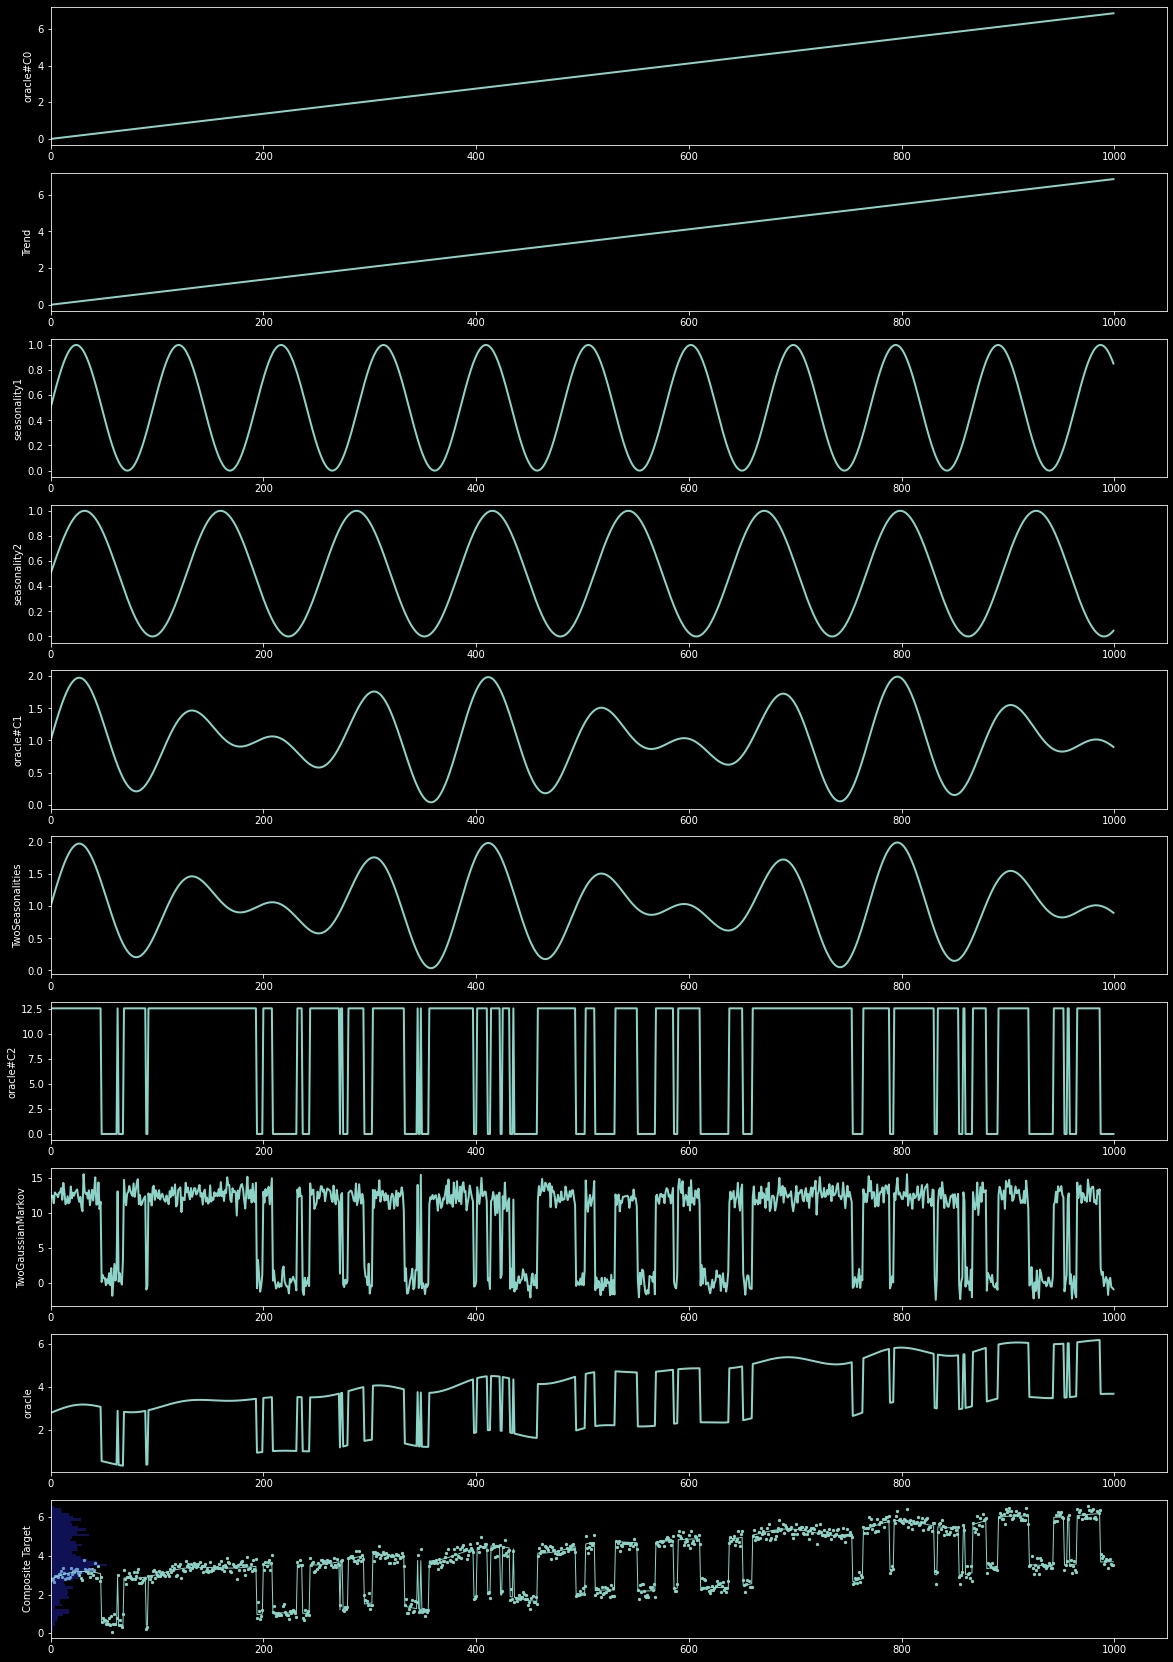

In [53]:
average.plot_components(oracle_on_target=True);

# Synthetic Test Suite

## Basic synthetic series

In [54]:
%%runwrite -a timegym/data/synthetic.py

basic_synthetics = [
    gaussian,
    uniform,
    trend_clean,
    trend_small_noise,
    trend_big_noise,
    seasonality,
    seasonality_noisy,
    two_seasonalities_noisy,
    trend_seasonality,
    anomalies,
    weekdays
]

## Extended synthetic series

In [55]:
%%runwrite -a timegym/data/synthetic.py

extended_synthetics = [
    gaussian,
    uniform,
    symdirichlet,
    two_markov,
    two_markov_fast,
    two_gaussians,
    two_gaussians_imbalanced,
    two_gaussians_markov,
    trend_clean,
    trend_small_noise,
    trend_big_noise,
    seasonality,
    two_seasonalities,
    seasonality_noisy,
    two_seasonalities_noisy,
    trend_seasonality,
    weekdays,
    anomalies
]

# Pipeline.py

## Boilerplate code

In [56]:
%%runwrite timegym/pipeline.py

import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from sktime.utils.validation._dependencies import _check_soft_dependencies
from sktime.utils.validation.forecasting import check_y
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import RecursiveRegressionForecaster
from sktime.forecasting.compose import DirectRegressionForecaster
#from sktime.forecasting.compose import MultioutputRegressionForecaster
from sklearn.pipeline import Pipeline as SkPipeline
from sktime.performance_metrics.forecasting import smape_loss
# other metrics: https://stats.stackexchange.com/questions/425390/how-do-i-decide-when-to-use-mape-smape-and-mase-for-time-series-analysis-on-sto
import types
from sklearn.base import TransformerMixin, RegressorMixin
from collections import defaultdict
from sktime.forecasting.naive import NaiveForecaster
import inspect
from tqdm.auto import tqdm
#from pqdm.threads import pqdm
#from pqdm.processes import pqdm
import seaborn as sns


class FunctionTransformation(TransformerMixin):
    def __init__(self, transformation, **hyperparameters):
        self.transformation = transformation
        self.hyperparameters = hyperparameters

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return self.transformation(X, **self.hyperparameters)
    
    
class Pipeline:
    
    def __init__(self, strategy='recursive', window_length=100):
        """
        """
        self.strategy = strategy
        self.window_length = window_length
        self.steps = []
    
    
    def sample_hyperparameters(search_space: dict):
        raise NotImplementedError
        #for hyperparameter in search_space:
            
        
    
    def add(self, transformation, append=False, **hyperparameters):
        """Adds one transformation step to the pipeline
        
        Parameters
        ----------
        transformation : sklearn.base.TransformerMixin, function
            One transformation class, or a function.
        **hyperparamters : string, int, float, optuna.suggestion, optional (default=None)
            other hyperparameters to be initialized  of series, will be displayed in figure legend
        Returns
        -------
        fig : plt.Figure
        ax : plt.Axis
        """
        if hyperparameters:
            for h in hyperparameters:
                if isinstance(hyperparameters[h], tuple):
                    #TODO: use optuna to generate these hyperparameters dymically if requested by user
                    raise NotImplementedError
        
        if inspect.isfunction(transformation):
            transformation = FunctionTransformation(partial(transformation, **hyperparameters))
        elif inspect.isclass(transformation):
            transformation = transformation(**hyperparameters)
            if isinstance(transformation, BaseEstimator):
                pass
            elif not isinstance(transformation, TransformerMixin):
                raise NotImplementedError
                #transformation = FunctionTransformation(transformations)
            
        self.steps.append(transformation)
        
    
    def predict(self, y_train, y_test):
        # TODO: add support for time series regression
        #DirectTimeSeriesRegressionForecaster
        #RecursiveTimeSeriesRegressionForecaster
        
        if isinstance(self.steps[-1], RegressorMixin):
            # convert pipeline steps to a sklearn pipeline
            pipeline = SkPipeline([(type(step).__name__, step) for step in self.steps])
    
            # create the forecaster according to one of the following strategies: 
            # 'recursive' (default), 'direct', 'combination', 'multioutput'
            if self.strategy=='recursive':
                forecaster = RecursiveRegressionForecaster(pipeline, window_length=self.window_length)
            elif self.strategy=='direct': 
                forecaster = DirectRegressionForecaster(pipeline)
            elif self.strategy=='combination':
                raise NotImplementedError 
            elif self.strategy=='multioutput':
                #forecaster = MultioutputRegressionForecaster(pipeline)
                #better code still yet to come
                raise NotImplementedError
        else: #ASSUME THAT LAST STEP IS A FORECASTER
            # convert pipeline steps to a sklearn pipeline (except for the last step
            pipeline = SkPipeline([(type(step).__name__, step) for step in self.steps[:-1]])
            y_train = pipeline.fit_transform(y_train)
            forecaster = self.steps[-1]
                
        forecaster = forecaster.fit(y_train)
        y_pred = forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False))
        return y_pred
    
    def plot_tests(self, datasets=basic_synthetics, tests_per_dataset=3, naive=None):
        """
        plot_tests plots a matrix plot of forecasts including the ideal 'oracle' values.
        
        Parameters
        ----------
        datasets : list of datasets, optional (default=timegym.synthetic.basic_synthetics)
            List of datasets used for the tests.
            
        tests_per_dataset : int, optional (default=3)
            Number of tests generated per dataset.
            
        naive : str{"last", "mean", "drift"}, optional (default=None)
            Naive strategy used to make forecasts:
            * "last" : forecast the last value in the
                        training series when sp is 1.
                        When sp is not 1,
                        last value of each season
                        in the last window will be
                        forecasted for each season.
            * "mean" : forecast the mean of last window
                         of training series when sp is 1.
                         When sp is not 1, mean of all values
                         in a season from last window will be
                         forecasted for each season.
            * "drift": forecast by fitting a line between the
                        first and last point of the window and
                         extrapolating it into the future
        """
        self.__forecaster = self.steps[-1]
        
        fig, axes = plt.subplots(nrows=len(datasets), ncols=tests_per_dataset, 
                                 figsize=(tests_per_dataset*10,len(datasets)*5),
                                 squeeze=False)

        for d, dataset in enumerate(datasets):
            axes[d, 0].set_ylabel(dataset.shortname)
            for t in range(tests_per_dataset):
                # training and test
                y_train, y_test, oracle = dataset.get_data()
                y_pred = self.predict(y_train, y_test)
                smape_pred = smape_loss(oracle[y_test.index], y_pred) # pred vs oracle
                smape_noise = smape_loss(oracle[y_test.index], y_test) # noisy-signal vs oracle 
                pd.Series(oracle).plot(ax=axes[d, t], color='gray', label='Oracle (noiseless signal)', legend=True, linewidth=1)
                pd.Series(pd.concat([y_train, y_test])).plot(ax=axes[d, t], color='gray', label='Observations (sMAPE: {:.3f})'.format(smape_noise), legend=True, marker='.', markersize=2, linewidth=0)
                pd.Series(y_pred).plot(ax=axes[d, t], color='blue', label='Predictions (sMAPE: {:.3f})'.format(smape_pred), legend=True, marker='x', markersize=1.5, linewidth=0)
                if naive:
                    naive_forecaster = NaiveForecaster(strategy=naive).fit(y_train)
                    y_pred_naive = naive_forecaster.predict(ForecastingHorizon(y_test.index, is_relative=False))
                    smape_naive = smape_loss(oracle[y_test.index], y_pred_naive) # naive vs oracle
                    pd.Series(y_pred_naive).plot(ax=axes[d, t], color='green', label='Naive (sMAPE: {:.3f})'.format(smape_naive), legend=True, marker='.', markersize=1, linewidth=0)
                split_date = y_train.index[-1] + (y_test.index[0] - y_train.index[-1])/2
                axes[d, t].axvline(split_date, color='blue', linewidth=2, linestyle='--')
                axes[d, t].set_xlim(xmin=oracle.index[0], xmax=oracle.index[-1])
                axes[d, t].legend(loc='upper left')
        return fig
    
    
    def plot_error(self, datasets=basic_synthetics, tests_per_dataset=100, n_jobs=4):
        self.__forecaster = self.steps[-1]
        
        fig, ax = plt.subplots(nrows=len(datasets), ncols=1, squeeze=False,
                                 figsize=(12, len(datasets)*5))
        
        def prediction_smape(d):
            y_train, y_test, oracle = datasets[d].get_data()
            y_pred = self.predict(y_train, y_test)
            return smape_loss(oracle[y_test.index], y_pred)

        tests_datasets_indices = list(range(len(datasets))) * tests_per_dataset
        results = []
        for d in tqdm(tests_datasets_indices):
            results.append(prediction_smape(d))
        results = pd.Series(results, index=tests_datasets_indices)
        
        # plot results
        for d in range(len(datasets)):
            sns.histplot(results.loc[d], ax=ax[d, 0], kde=True, stat='count', bins=tests_per_dataset//5)
            ax[d, 0].set
        return fig
    

## Tests

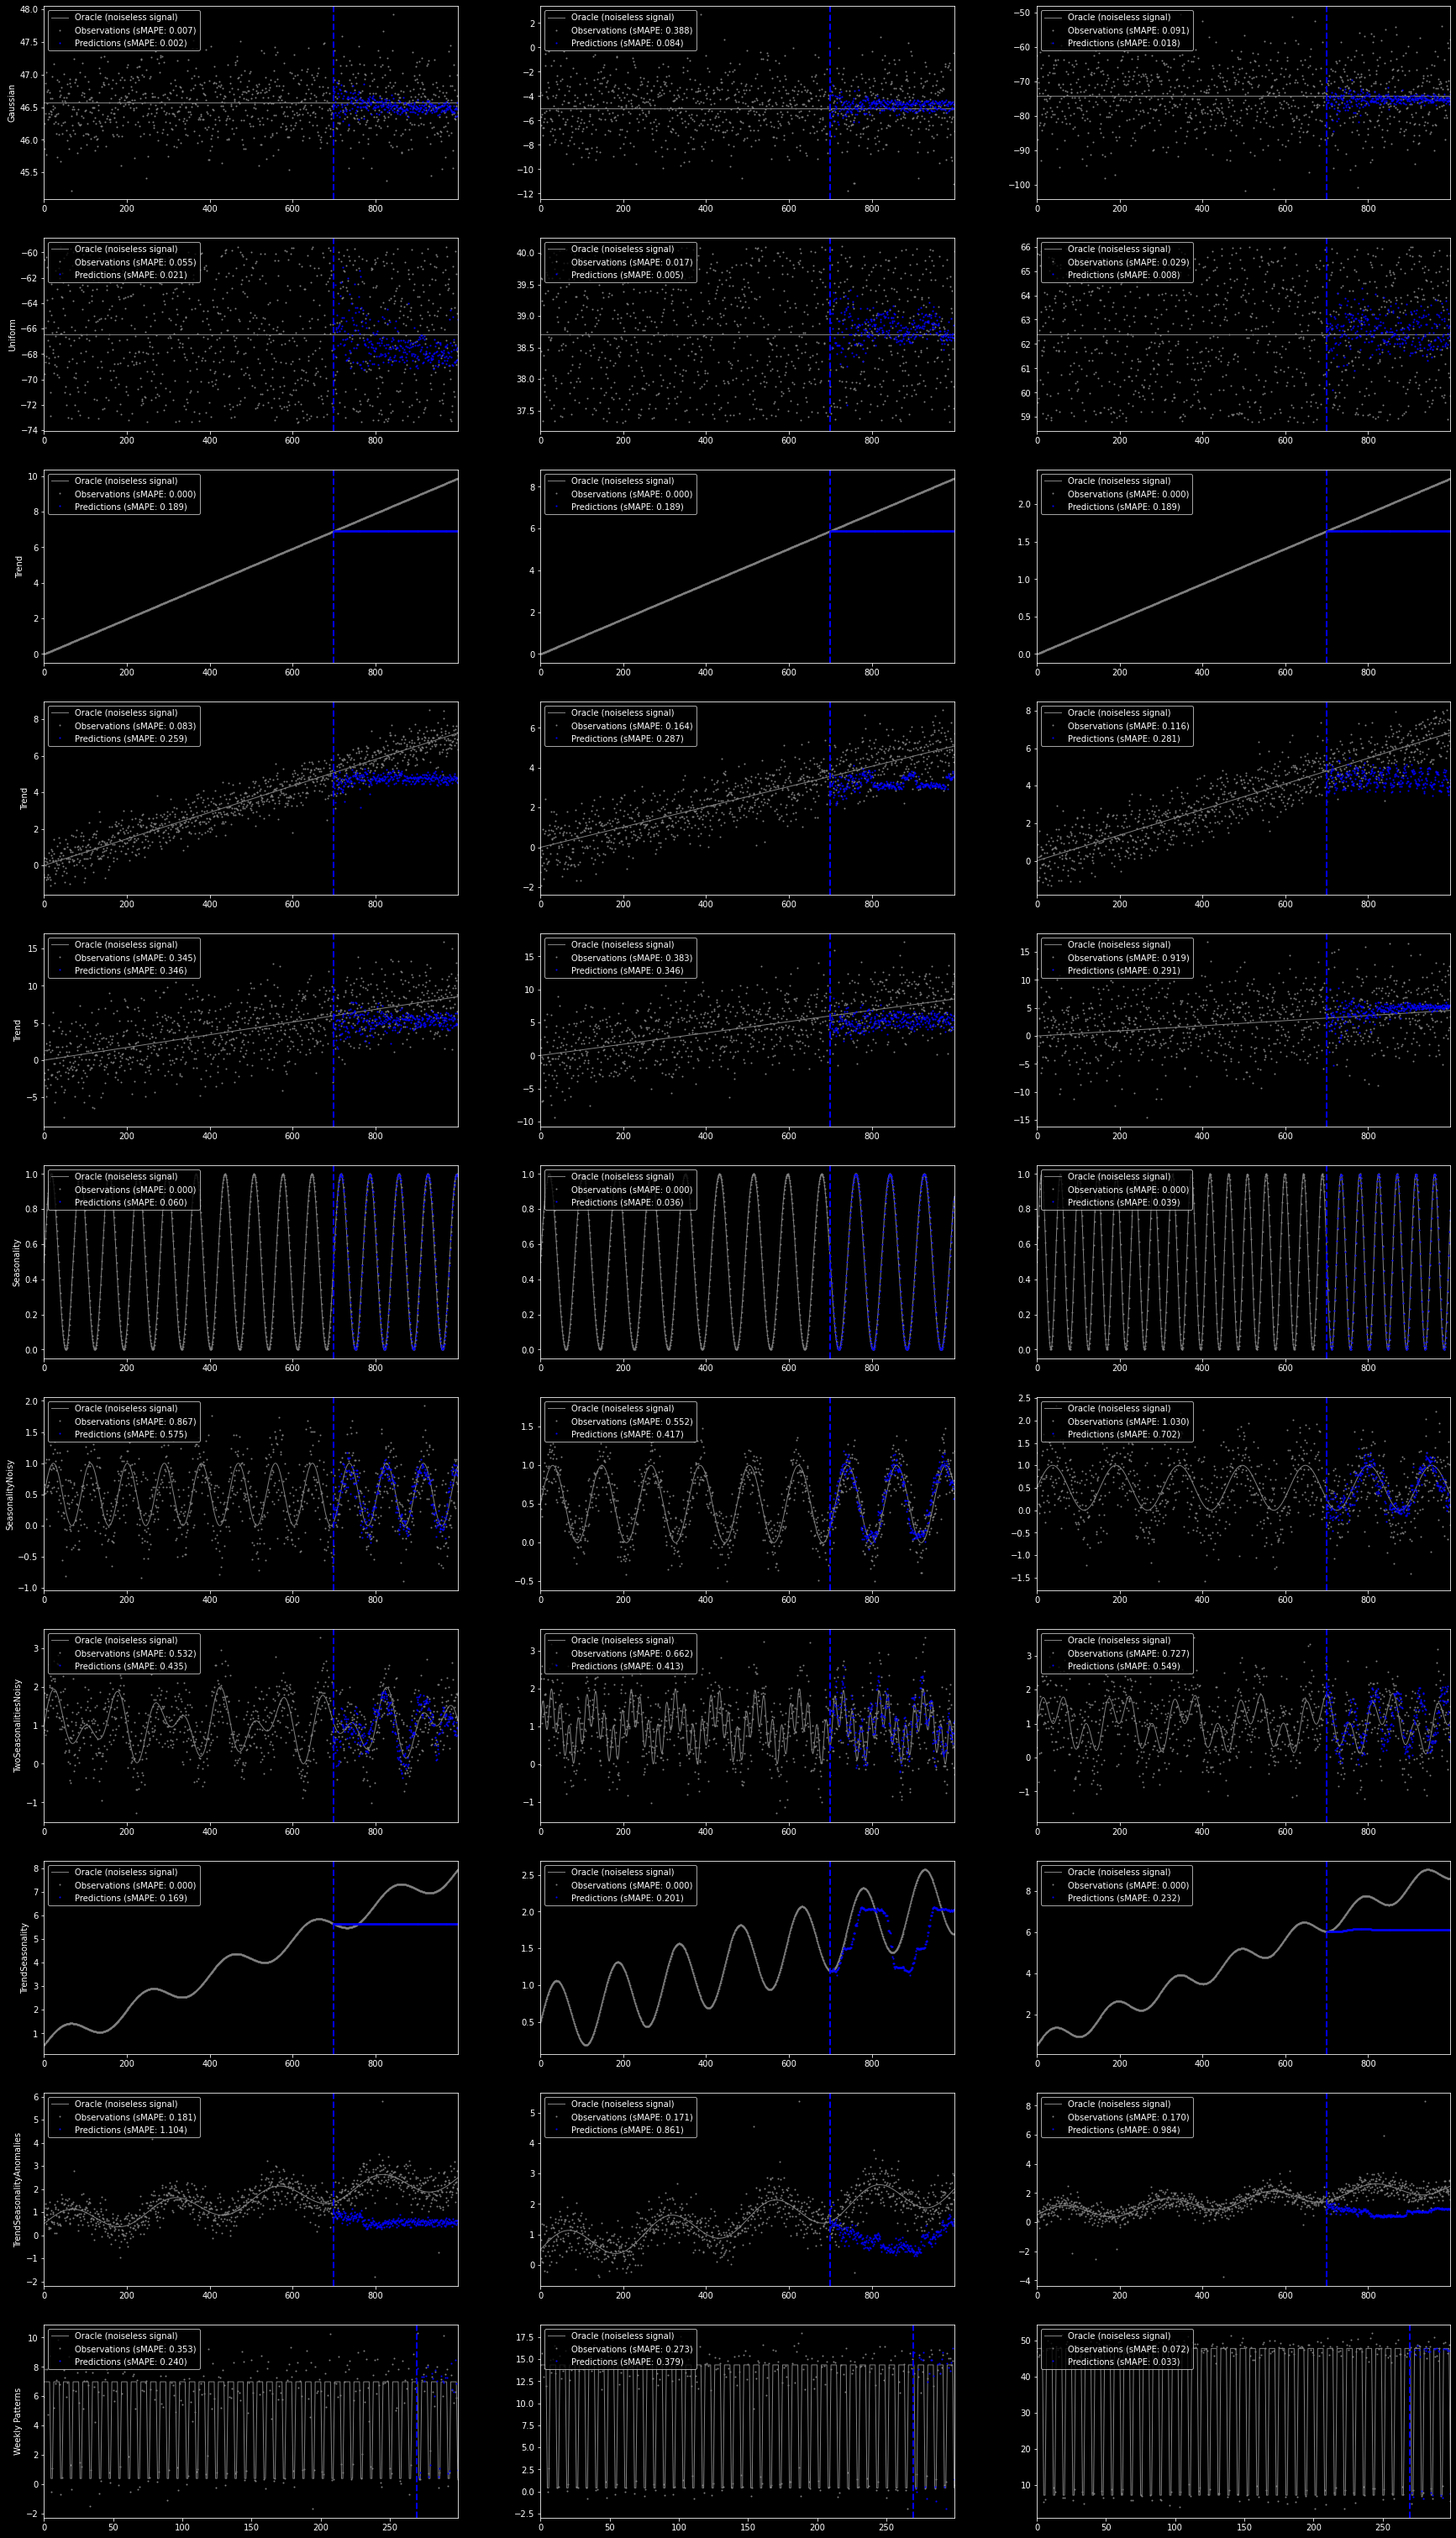

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor

pipeline = Pipeline()
pipeline.add(StandardScaler())
pipeline.add(PCA(0.95))
pipeline.add(XGBRegressor())
pipeline.plot_tests();

TODO: 

* contextualizar bem o uso do sMAPE 
* melhorar labeling dos plots

  0%|          | 0/1100 [00:00<?, ?it/s]

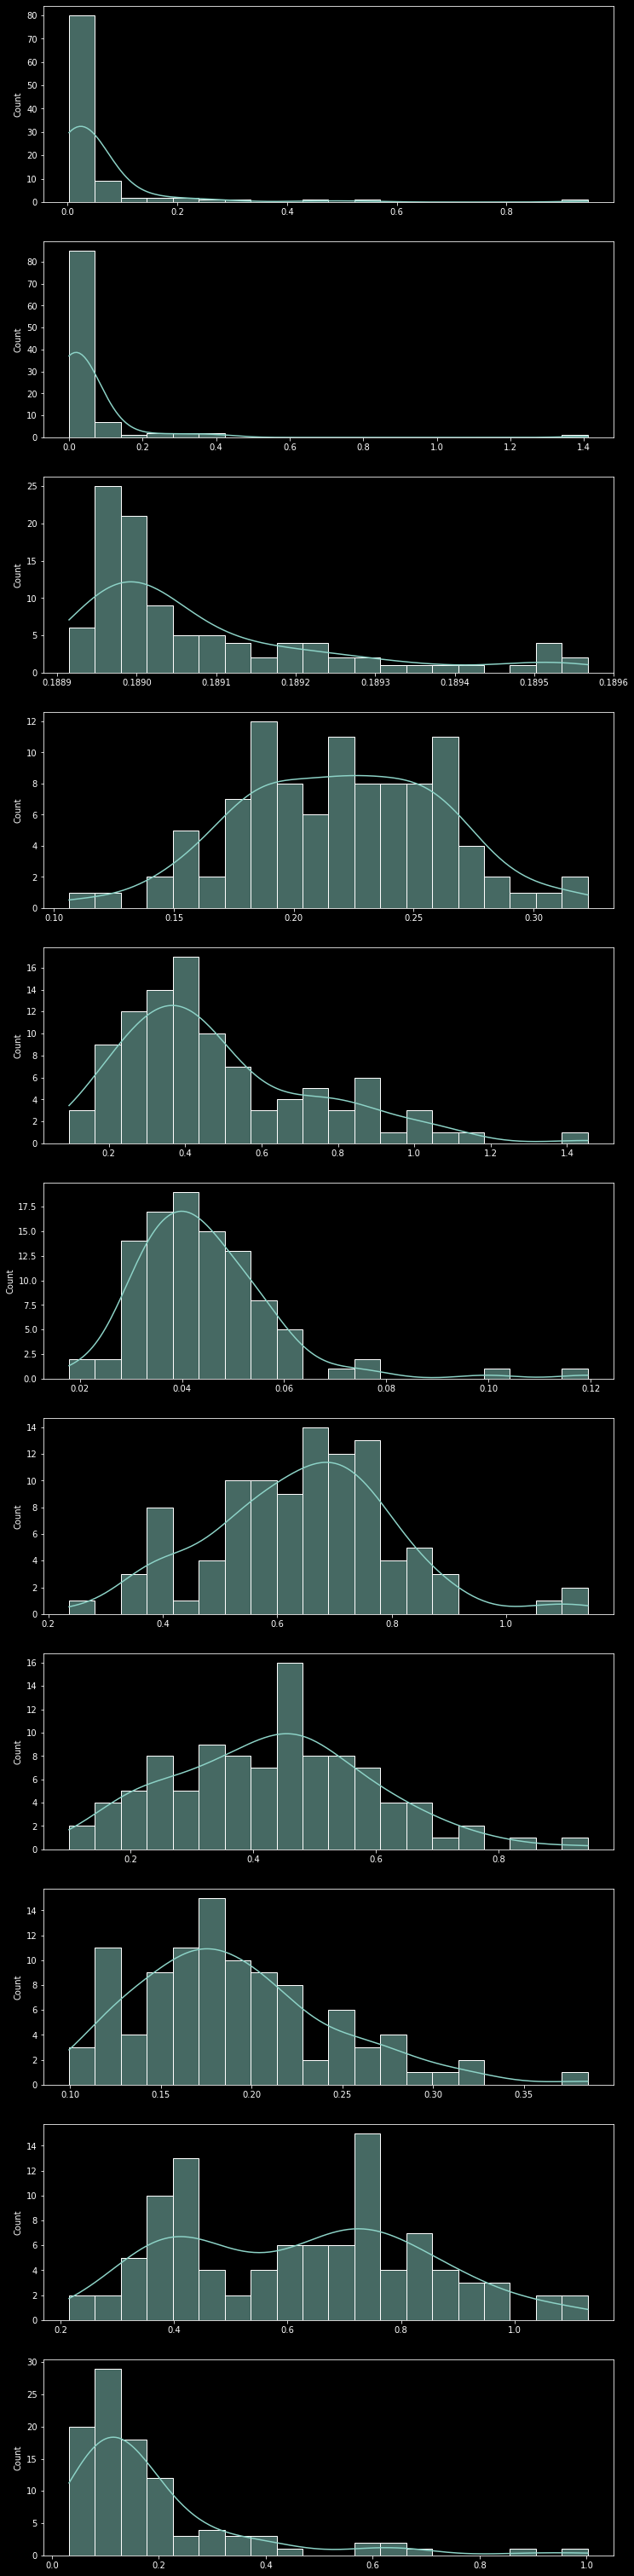

In [58]:
pipeline.plot_error();

In [ ]:
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

In [ ]:
TSFreshFeatureExtractor()

In [ ]:
ts = pd.Series(np.arange(1000))

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter
import pandas as pd

# Download dataset
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
download_robot_execution_failures()


df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)

augmenter = RelevantFeatureAugmenter(column_id='i', column_sort='time', timeseries_container=df_ts)
pipeline = Pipeline([('augmenter', augmenter),
            ('classifier', RandomForestClassifier())])

pipeline.fit(X, y)

In [ ]:
RelevantFeatureAugmenter

In [ ]:
tsf_features = RelevantFeatureAugmenter()
tsf_features.fit_transform(ts)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
#from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from tsfresh.transformers import RelevantFeatureAugmenter

pipeline = Pipeline()
pipeline.add(TSFreshFeatureExtractor(n_jobs=4))
pipeline.add(StandardScaler())
pipeline.add(PCA(0.95, whiten=True))
pipeline.add(KNeighborsRegressor(1))
pipeline.plot_tests();

TODO: 
* have training also include auto-optuna (or normalizing flow) on hyperparamters optimization (GP) for timesteps t+1..t+h

In [ ]:
def custom_moving_averages(X, window_length=30):
    X = pd.DataFrame(X)
    ma = X.rolling(window_length, min_periods=1).mean()
    return pd.concat([X, ma], axis=1)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomMovingAverages(BaseEstimator, TransformerMixin):    
    # this transformer takes a 2d array or a dataframe, and calculates moving averages of the first column
    
    def __init__(self, periods=[]):
        self.periods = periods
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = pd.DataFrame(X)
        for period in self.periods:
            X['MA'+str(period)] = X.iloc[:,0].rolling(period).mean()
        return X
    

In [ ]:
from sklearn.preprocessing import QuantileTransformer
from xgboost import XGBRegressor

pipeline = TabularRegressionPipeline()
pipeline.add(QuantileTransformer())
pipeline.add(XGBRegressor())
pipeline.test();

In [ ]:
from sktime.forecasting.arima import AutoARIMA

pipeline = Pipeline()
pipeline.add(AutoARIMA(sp=100, suppress_warnings=True))
pipeline.test();

In [ ]:
from sktime.forecasting.ets import AutoETS

pipeline = Pipeline()
pipeline = AutoETS(auto=True, sp=12, n_jobs=-1)
pipeline.test();

In [ ]:
class NewFeatureEngineeringF:
    
    def fit(self, X, y=None):
        self.mean = x.mean()
        self.std = x.std()
    
    def transform(self, X):
        return (x-self.mean())/self.std()
        

# Features Importance


>    "Explains predictions on tabular (i.e. matrix) data.
>    For numerical features, perturb them by sampling from a Normal(0,1) and
>    doing the inverse operation of mean-centering and scaling, according to the
>    means and stds in the training data. For categorical features, perturb by
>    sampling according to the training distribution, and making a binary
>    feature that is 1 when the value is the same as the instance being
>    explained." - Lime Documentation

Apply lime to all test observations, get a table with all magnitudes per feature. Then take those columns and plot as many distributions as there are features. This will allow you to gauge feature impact without the noise of means medians or standard deviations.

Similar to the Shap Explainer, we use LIME in order to identify those features which are most important.

# Shap Explainer

Plot https://github.com/slundberg/shap values like for the training split with the test. Try to add a vertical line:

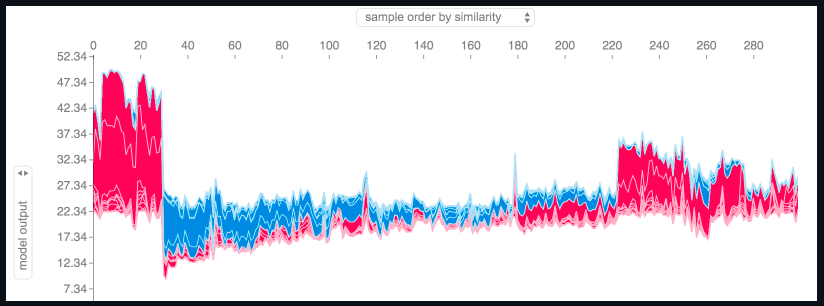

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
lime.lime_tabular.LimeTabularExplainer(training_data, 
                                       mode="classification", 
                                       training_labels=None, 
                                       feature_names=None, 
                                       categorical_features=None, 
                                       categorical_names=None, 
                                       kernel_width=None, 
                                       kernel=None, 
                                       verbose=False, 
                                       class_names=None, 
                                       feature_selection='auto', 
                                       discretize_continuous=True, 
                                       discretizer='quartile', 
                                       sample_around_instance=False, 
                                       random_state=None, 
                                       training_data_stats=None)